In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/ColabNotebooks/Shape.zip" -d "/content"

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/Shape/dataset/val/images/img_13531.png  
  inflating: /content/Shape/dataset/val/images/img_13537.png  
  inflating: /content/Shape/dataset/val/images/img_13541.png  
  inflating: /content/Shape/dataset/val/images/img_13548.png  
  inflating: /content/Shape/dataset/val/images/img_1356.png  
  inflating: /content/Shape/dataset/val/images/img_13560.png  
  inflating: /content/Shape/dataset/val/images/img_13567.png  
  inflating: /content/Shape/dataset/val/images/img_1358.png  
  inflating: /content/Shape/dataset/val/images/img_13583.png  
  inflating: /content/Shape/dataset/val/images/img_13587.png  
  inflating: /content/Shape/dataset/val/images/img_13590.png  
  inflating: /content/Shape/dataset/val/images/img_13600.png  
  inflating: /content/Shape/dataset/val/images/img_13601.png  
  inflating: /content/Shape/dataset/val/images/img_13602.png  
  inflating: /content/Shape/dataset/val/images/img_13603.png  
  inflating: /content/Sha

In [4]:
class ShapeDataset(Dataset):
    """
    複数の手書き風図形（円、三角形、四角形）を含む画像と、
    それに対応するラベル情報（クラス、位置、面積）を読み込む PyTorch Dataset クラス。
    """

    def __init__(self, image_dir, label_dir, file_list):
        """
        コンストラクタ

        Args:
            image_dir (str): 画像フォルダへのパス（例："images"）
            label_dir (str): ラベルファイルフォルダへのパス（例："labels"）
            file_list (List[str]): 対象の画像ファイル名（拡張子なし）のリスト（例: ['img_0001', 'img_0002']）
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.file_list = file_list

    def __len__(self):
        """
        データセットのサイズ（サンプル数）を返す

        Returns:
            int: サンプル数（画像数）
        """
        return len(self.file_list)

    def __getitem__(self, idx):
        """
        指定されたインデックスの画像とラベルを返す

        Args:
            idx (int): インデックス

        Returns:
            img (Tensor): 正規化されたグレースケール画像 [1, H, W]
            targets (Tensor): ラベル情報 [num_shapes, 6]
                              各行は [class_id, cx, cy, w, h, area]
        """
        # ファイル名のベース（拡張子なし）を取得
        base_name = self.file_list[idx]

        # 画像とラベルファイルのパスを構築
        img_path = os.path.join(self.image_dir, base_name + ".png")
        label_path = os.path.join(self.label_dir, base_name + ".txt")

        # 画像をグレースケールで読み込み（H, W）、[0, 255] → [0.0, 1.0] に変換
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype("float32") / 255.0

        # [H, W] → [1, H, W] に次元追加（PyTorchの入力に合わせる）
        img = torch.from_numpy(img).unsqueeze(0)

        # ラベル（複数図形）を読み込んで Tensor に変換
        targets = []
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                class_id = int(parts[0])  # クラス（0=円, 1=三角形, 2=四角形）
                cx, cy, w, h, area = map(float, parts[1:])  # 正規化された中心座標・サイズ・面積
                targets.append([class_id, cx, cy, w, h, area])

        # [num_shapes, 6] の Tensor に変換
        targets = torch.tensor(targets, dtype=torch.float32)

        return img, targets

In [5]:
def collate_fn(batch):
    imgs = torch.stack([item[0] for item in batch], dim=0)  # 画像は同じサイズなのでstack可能
    targets = [item[1] for item in batch]  # targetsはリストのまま
    return imgs, targets

"""
学習・検証用の DataLoader を準備するスクリプト
分割済みの dataset/train/ と dataset/val/ を対象に Dataset を構築
"""

# ディレクトリパス
base_dir = "/content/Shape/dataset"
train_image_dir = os.path.join(base_dir, "train", "images")
train_label_dir = os.path.join(base_dir, "train", "labels")
val_image_dir = os.path.join(base_dir, "val", "images")
val_label_dir = os.path.join(base_dir, "val", "labels")

# ファイル名一覧（拡張子なし）を取得
train_files = [os.path.splitext(f)[0] for f in os.listdir(train_image_dir)]
val_files   = [os.path.splitext(f)[0] for f in os.listdir(val_image_dir)]

# ソートしておくと順序が安定
train_files.sort()
val_files.sort()

# Dataset を作成
train_dataset = ShapeDataset(train_image_dir, train_label_dir, train_files)
val_dataset   = ShapeDataset(val_image_dir, val_label_dir, val_files)

# DataLoader を作成
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

print(f"✅ DataLoader 準備完了：train={len(train_dataset)}枚 / val={len(val_dataset)}枚")

✅ DataLoader 準備完了：train=12000枚 / val=3000枚


In [7]:
class YOLOShapeDetector(nn.Module):
    """
    任意個数の図形（円・三角・四角）を検出するYOLO風の軽量ネットワーク。
    1つの出力セルあたり B個の予測ボックスを出力。
    """

    def __init__(self, S=16, B=2, num_classes=3):
        """
        Args:
            S (int): 出力グリッドの分割数（S x Sセル）
            B (int): 1セルあたりの予測ボックス数
            num_classes (int): クラス数（今回は 3：円・三角・四角）
        """
        super().__init__()
        self.S = S
        self.B = B
        self.num_classes = num_classes
        self.output_dim = B * (1 + 4 + num_classes + 1)  # objectness + bbox + class probs + area

        # 軽量CNNバックボーン
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # 入力はグレースケール画像 (1, H, W)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 256x256

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x128

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16 → S=16 に一致
        )

        # 出力層：S×SセルごとにB個の予測（objectness + bbox + class + area）
        self.pred_head = nn.Conv2d(256, self.output_dim, kernel_size=1)

    def forward(self, x):
        """
        入力画像から予測を出力

        Args:
            x (Tensor): [B, 1, H, W] のグレースケール画像

        Returns:
            Tensor: [B, S, S, B, 7 + num_classes] の予測
        """
        feat = self.features(x)  # [B, 256, S, S]
        out = self.pred_head(feat)  # [B, output_dim, S, S]

        B, C, S, S = out.shape
        out = out.permute(0, 2, 3, 1).contiguous()  # [B, S, S, output_dim]

        out = out.view(B, S, S, self.B, -1)  # [B, S, S, B, 6 + num_classes]

        return out

In [8]:
def compute_yolo_loss(preds, targets, S=16, B=2, num_classes=3, lambda_coord=5.0, lambda_noobj=0.5, lambda_area=1.0):
    """
    YOLO形式のマルチタスク損失関数（本番用）
    - バウンディングボックス回帰（cx, cy, w, h）
    - クラス分類（クロスエントロピー）
    - 面積回帰（回帰損失）
    - objectness（二値分類）

    Args:
        preds: Tensor [B, S, S, B, 1 + 4 + num_classes + 1]
               モデルの出力
        targets: list[list]（各バッチごとのラベルリスト）
               各要素は [class_id, cx, cy, w, h, area]
        S: 出力グリッド数（S × S）
        B: 各グリッドセルあたりの予測ボックス数
        num_classes: 図形クラス数（円・三角形・四角形 → 3）
        lambda_coord: bbox回帰の重み（デフォルト: 5.0）
        lambda_noobj: objectnessが0のセルの損失重み（デフォルト: 0.5）
        lambda_area: 面積回帰損失の重み（デフォルト: 1.0）

    Returns:
        総合損失（スカラー）
    """

    device = preds.device
    batch_size = preds.shape[0]
    loss = 0.0  # 総損失初期化

    for b in range(batch_size):
        # 1バッチ分の空ラベルテンソルを準備（予測と同形式）
        target_tensor = torch.zeros((S, S, B, 1 + 4 + num_classes + 1), device=device)

        for t in targets[b]:
            # クラス・位置・サイズ・面積を取得
            class_id, cx, cy, w, h, area = t
            class_id = int(class_id)

            # 対応するグリッドセル座標を取得（整数）
            grid_x = int(cx * S)
            grid_y = int(cy * S)

            # セル内での相対座標（0〜1）
            gx = cx * S - grid_x
            gy = cy * S - grid_y

            if grid_x >= S or grid_y >= S:
                continue  # 画像外には登録しない（保険）

            # B個の枠のうち、最初の空きスロットに登録
            for box in range(B):
                if target_tensor[grid_y, grid_x, box, 0] == 0:
                    # objectness = 1
                    target_tensor[grid_y, grid_x, box, 0] = 1.0

                    # bbox座標（セル内）
                    target_tensor[grid_y, grid_x, box, 1:5] = torch.tensor([gx, gy, w, h], device=device)

                    # クラス one-hot（例: [0,1,0]）
                    target_tensor[grid_y, grid_x, box, 5 + class_id] = 1.0

                    # 面積
                    target_tensor[grid_y, grid_x, box, -1] = area
                    break

        # 対象バッチの予測とラベルを取得
        pred = preds[b]     # [S, S, B, D]
        target = target_tensor

        # objectness マスク（物体あり / なし）
        obj_mask = target[..., 0] == 1
        noobj_mask = target[..., 0] == 0

        # ---------- 損失計算 -----------

        # 1. objectness（二値分類）: BCE Loss
        bce_obj = F.binary_cross_entropy_with_logits(
            pred[..., 0], target[..., 0], reduction='none'
        )
        loss += (bce_obj * obj_mask).sum() + lambda_noobj * (bce_obj * noobj_mask).sum()

        # 2. bbox（回帰）: MSE Loss（物体がある場所だけ）
        if obj_mask.any():
            loss += lambda_coord * F.mse_loss(
                pred[..., 1:5][obj_mask],
                target[..., 1:5][obj_mask],
                reduction='sum'
            )

            # 3. クラス分類: Cross Entropy（物体がある場所だけ）
            pred_cls = pred[..., 5:5+num_classes][obj_mask]               # [N, C]
            target_cls = target[..., 5:5+num_classes][obj_mask]           # [N, C]
            target_cls_ids = target_cls.argmax(dim=-1)                    # [N]
            loss += F.cross_entropy(pred_cls, target_cls_ids, reduction='sum')

            # 4. 面積回帰: MSE Loss（物体がある場所だけ）
            pred_area = pred[..., -1][obj_mask]
            target_area = target[..., -1][obj_mask]
            loss += lambda_area * F.mse_loss(pred_area, target_area, reduction='sum')

    return loss / batch_size  # バッチ平均で正規化

In [10]:
'''
# モデル、損失関数、データセットをインポート
from model import YOLOShapeDetector              # YOLO風の図形検出モデル
from loss import compute_yolo_loss              # カスタム損失関数（分類・回帰・面積・objectness）
from dataset import ShapeDataset                # 自作の図形データセットクラス
'''

# --- ハイパーパラメータ設定 ---
S = 16                       # 出力グリッド数（S x S に分割）
B = 2                        # 1セルあたりの予測ボックス数
num_classes = 3              # クラス数（円・三角・四角）
input_size = 512             # 入力画像のサイズ（縦横）
batch_size = 8              # バッチサイズ
num_epochs = 30              # 総エポック数
learning_rate = 1e-3         # 学習率
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 使用デバイス

# --- モデルと最適化の定義 ---
model = YOLOShapeDetector(S=S, B=B, num_classes=num_classes).to(device)  # モデル構築＆GPUへ転送
optimizer = optim.Adam(model.parameters(), lr=learning_rate)             # 最適化アルゴリズムにAdamを使用
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# --- ロス記録用リスト ---
train_losses = []
val_losses = []

save_dir = "/content/drive/MyDrive/ColabNotebooks/model"
os.makedirs(save_dir, exist_ok=True)

# --- 学習ループ ---
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for imgs, targets in train_loader:
        imgs = imgs.to(device)
        preds = model(imgs)
        loss = compute_yolo_loss(preds, targets, S=S, B=B, num_classes=num_classes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- 検証ループ ---
    model.eval()  # 推論モードに切り替え（DropoutやBatchNormを無効に）
    total_val_loss = 0.0
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = imgs.to(device)
            preds = model(imgs)
            loss = compute_yolo_loss(preds, targets, S=S, B=B, num_classes=num_classes)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # --- エポックごとの結果表示 ---
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # --- モデル保存 ---
    torch.save(model.state_dict(), os.path.join(save_dir, f"epoch{epoch + 1}.pth"))
    #torch.save(model.state_dict(), "shape_detector.pth")

Epoch [1/30] Train Loss: 16.2174 | Val Loss: 6.2691
Epoch [2/30] Train Loss: 6.0603 | Val Loss: 5.4416
Epoch [3/30] Train Loss: 5.1812 | Val Loss: 8.0258
Epoch [4/30] Train Loss: 4.7350 | Val Loss: 4.8579
Epoch [5/30] Train Loss: 4.5083 | Val Loss: 4.9852
Epoch [6/30] Train Loss: 4.3536 | Val Loss: 4.4705
Epoch [7/30] Train Loss: 4.2022 | Val Loss: 6.1524
Epoch [8/30] Train Loss: 4.0438 | Val Loss: 4.3461
Epoch [9/30] Train Loss: 3.9138 | Val Loss: 4.4127
Epoch [10/30] Train Loss: 3.7886 | Val Loss: 4.1891
Epoch [11/30] Train Loss: 3.6975 | Val Loss: 4.1622
Epoch [12/30] Train Loss: 3.5707 | Val Loss: 4.1517
Epoch [13/30] Train Loss: 3.4490 | Val Loss: 4.1731
Epoch [14/30] Train Loss: 3.4045 | Val Loss: 4.1508
Epoch [15/30] Train Loss: 3.2437 | Val Loss: 4.2144
Epoch [16/30] Train Loss: 3.1204 | Val Loss: 4.2438
Epoch [17/30] Train Loss: 3.0417 | Val Loss: 4.1396
Epoch [18/30] Train Loss: 2.9156 | Val Loss: 4.1636
Epoch [19/30] Train Loss: 2.8315 | Val Loss: 4.2470
Epoch [20/30] Train 

KeyboardInterrupt: 

📊 ロスグラフを loss_curve.png に保存しました


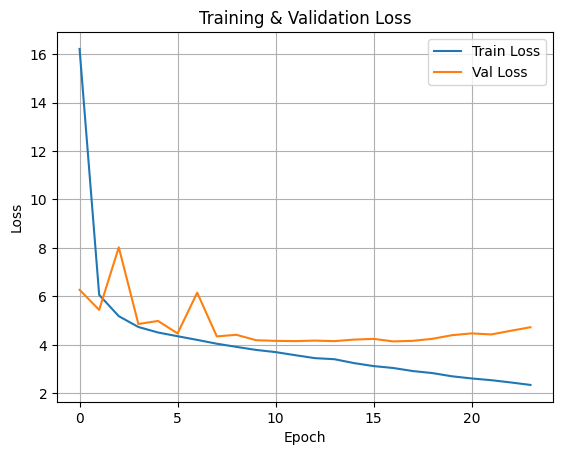

In [11]:
# --- ロスの可視化（任意）---
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")
print("📊 ロスグラフを loss_curve.png に保存しました")